In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import nn 
from torch import optim
from torch.autograd import Variable

from sklearn.metrics import accuracy_score

1). Добиться вразумительного результата от модели, собранной на занятии (3 угаданные картинки из 4 предложенных на семинаре). Варианты изменений:
 - изменение слоёв и их количества;
 - изменение метода оптимизации; 
 - изменение процесса обучения; 
 - для продвинутых: преобразование данных.

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='/content/data',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)


image, label = train_dataset[0]
print (image.size())
print (label)

Extracting /content/data/cifar-10-python.tar.gz to /content/data
torch.Size([3, 32, 32])
6


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

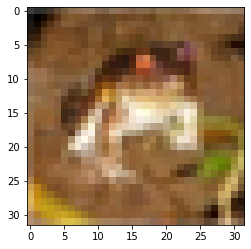

In [7]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=40, 
                                           shuffle=True)

In [9]:
test_dataset = torchvision.datasets.CIFAR10(root='/content/data', train=False,
                                       download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                         shuffle=False)

Files already downloaded and verified


Переписал на pytorch модель отсюда:
 - https://github.com/NovikovVN/neural_networks/blob/master/intro/neural_networks04.ipynb

In [32]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 5, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 5, padding=1)
        self.pool2 = nn.MaxPool2d((2, 2), stride=1)
        self.fc1 = nn.Linear(64 * 9 * 9, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))        
        x = self.dropout(x)
        x = x.view(-1, 64 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


net = Net().to('cpu')

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
%%time
for epoch in range(20):  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            _, predicted = torch.max(outputs, 1)
            accuracy = accuracy_score(labels, predicted)
            print('[%d, %5d] loss: %.6f accuracy: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000, accuracy))
            running_loss = 0.0

print('Training is finished!')

[1,     1] loss: 0.001153 acuuracy: 0.050
[1,   301] loss: 0.345507 acuuracy: 0.150
[1,   601] loss: 0.345422 acuuracy: 0.025
[1,   901] loss: 0.345241 acuuracy: 0.075
[1,  1201] loss: 0.345090 acuuracy: 0.125
[2,     1] loss: 0.001156 acuuracy: 0.000
[2,   301] loss: 0.344103 acuuracy: 0.075
[2,   601] loss: 0.337429 acuuracy: 0.175
[2,   901] loss: 0.315847 acuuracy: 0.100
[2,  1201] loss: 0.304430 acuuracy: 0.275
[3,     1] loss: 0.001071 acuuracy: 0.125
[3,   301] loss: 0.297101 acuuracy: 0.300
[3,   601] loss: 0.291567 acuuracy: 0.200
[3,   901] loss: 0.283098 acuuracy: 0.300
[3,  1201] loss: 0.273909 acuuracy: 0.275
[4,     1] loss: 0.000950 acuuracy: 0.350
[4,   301] loss: 0.265296 acuuracy: 0.350
[4,   601] loss: 0.260097 acuuracy: 0.275
[4,   901] loss: 0.255848 acuuracy: 0.475
[4,  1201] loss: 0.250332 acuuracy: 0.350
[5,     1] loss: 0.000702 acuuracy: 0.550
[5,   301] loss: 0.245818 acuuracy: 0.250
[5,   601] loss: 0.242237 acuuracy: 0.450
[5,   901] loss: 0.237133 acuuracy

In [351]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

GroundTruth:    cat


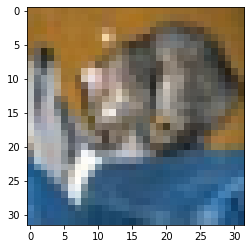

In [352]:
outputs = net(images)
imgs = torchvision.utils.make_grid(images)
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [26]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(1)))

Predicted:    cat


In [26]:
labels

tensor([0, 8, 9, 6, 3, 3, 1, 5, 9, 7, 3, 2, 2, 1, 7, 5, 3, 2, 6, 1, 9, 1, 2, 3,
        9, 7, 7, 4, 6, 4, 3, 9, 2, 1, 2, 8, 2, 5, 7, 0])

In [29]:
_, predicted = torch.max(outputs, 1)
predicted

tensor([0, 3, 3, 9, 0, 7, 2, 6, 1, 9, 0, 0, 2, 3, 6, 7, 2, 6, 6, 6, 8, 9, 6, 4,
        1, 7, 7, 3, 8, 7, 1, 4, 9, 0, 6, 9, 6, 3, 9, 4])

0.125

2). Взять часть, где мы делали один шаг обучения, и обернуть его в цикл по схеме, как обучали модель в конце занятия.

In [30]:
def print_tens_info(tensor):
    print("X :\n%s\n" % tensor)
    print("X количество измерений:\n%s\n" % tensor.dim())
    print("X размеры : ",  tensor.size())
    print("X тип : %s\n" % (tensor.type()))
#     print("Добавим 10 :\n%s\n" % (tensor + 10))
#     print("Среднее по строчке :\n%s\n" % (tensor.mean(axis=-1)))
#     print("Среднее по столбцу :\n%s\n" % (tensor.mean(axis=0)))
    

In [110]:
x = Variable(torch.randn(2), requires_grad = True)
y = Variable(torch.randn(2), requires_grad = False)

In [111]:
print_tens_info(X)

X :
tensor([ 0.3608, -0.1582])

X количество измерений:
1

X размеры :  torch.Size([2])
X тип : torch.FloatTensor



In [112]:
linear = nn.Linear(2, 2)

In [113]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

In [114]:
for i in range(1000):  
    optimizer.zero_grad()

    pred = linear(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()

    if i % 20 == 0:
        print('[%3d] loss: %.6f' %
                  (i, loss.item()))        

    if loss.item() <= 1e-6:
        break

[  0] loss: 1.175266
[ 20] loss: 0.440526
[ 40] loss: 0.165123
[ 60] loss: 0.061893
[ 80] loss: 0.023199
[100] loss: 0.008696
[120] loss: 0.003259
[140] loss: 0.001222
[160] loss: 0.000458
[180] loss: 0.000172
[200] loss: 0.000064
[220] loss: 0.000024
[240] loss: 0.000009
[260] loss: 0.000003
[280] loss: 0.000001
[300] loss: 0.000000
[320] loss: 0.000000


In [120]:
print('y:    ', y)
print('pred: ', pred)

y:     tensor([ 0.3608, -0.1582])
pred:  tensor([ 0.3604, -0.1580], grad_fn=<AddBackward0>)


3). Переписать эту программу на PyTorch: 
![img/img.png](img/img.png)
<br>Не забудьте про реализацию функции forward! 

In [240]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc2(x), dim=-1)
        # x = self.fc2(x)
        return x


net3 = Net3().to('cpu')

In [228]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net3.parameters())

In [241]:
x3 = Variable(torch.randn((28, 28)), requires_grad = True)
x3.size()

torch.Size([28, 28])

In [255]:
y3 = np.zeros(10)
y3[3] = 1.

y3 = Variable(torch.tensor(y3.reshape(1, 1, 10)), requires_grad = False)
y3.size()

torch.Size([1, 1, 10])

In [256]:
pred3 = net3(x3)
pred3.size()

torch.Size([1, 10])

In [257]:
pred3

tensor([[-0.4023, -0.0394, -0.1181, -0.2914, -0.2820, -0.1541,  0.0940,  0.0717,
         -0.0481, -0.0045]], grad_fn=<AddmmBackward>)